In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import norm
import seaborn as sns
from tabulate import tabulate
import requests
import statsmodels.api as sm
import cvxpy as cp

In [39]:
#Fetching Close and Return data
def fetch_data(tickers, start=None, end=None):
    # Validate start date
    if not start:
        raise ValueError("❌ Start date is required in 'YYYY-MM-DD' format.")
    try:
        datetime.strptime(start, "%Y-%m-%d")
    except ValueError:
        raise ValueError("❌ Start date must be in 'YYYY-MM-DD' format (e.g., 2020-01-01).")

    # Validate end date if provided
    if end:
        try:
            datetime.strptime(end, "%Y-%m-%d")
        except ValueError:
            raise ValueError("❌ End date must be in 'YYYY-MM-DD' format (e.g., 2020-12-31).")

    data = yf.download(tickers, start=start, end=end, group_by='ticker', interval='1mo', auto_adjust=True)

    # Handle both single and multi-level column format
    if isinstance(data.columns, pd.MultiIndex):
        try:
            adj_close = data.xs('Close', level=1, axis=1)
        except KeyError:
            raise ValueError("❌ 'Adj Close' prices not found — possibly all tickers failed.")
    else:
        if 'Close' in data.columns:
            adj_close = data['Close'].to_frame()
        else:
            raise ValueError("❌ No 'Adj Close' in single-column format.")

    adj_close = adj_close.dropna(axis=1, how='all')

    # Detect successful and failed tickers
    successful = list(adj_close.columns)
    failed = [t for t in tickers if t not in successful]

    if not successful:
        raise ValueError("❌ All tickers failed to download.")

    if failed:
        print(f"⚠️ The following tickers failed to download (check for typos or delisting): {failed}")

    returns = adj_close.pct_change().dropna()
    return adj_close, returns

In [47]:
#Regression Summary and coefficient calculation
def ff3_regression_analysis(merged_data):
    # Initialize storage lists
    alpha_list, mkt_list, smb_list, hml_list = [], [], [], []
    stderr_alpha, stderr_mkt, stderr_smb, stderr_hml = [], [], [], []

    tickers = merged_data['Ticker'].unique()

    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker]
        X = group[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = group['Excess Return']

        model = sm.OLS(y, X).fit()
        print(f"\n📊 Regression Summary for {ticker}")
        print(model.summary(), end="\n\n")
        # Coefficients
        alpha_list.append(model.params['const'])
        mkt_list.append(model.params['Mkt-RF'])
        smb_list.append(model.params['SMB'])
        hml_list.append(model.params['HML'])

        # Standard errors
        stderr_alpha.append(model.bse['const'])
        stderr_mkt.append(model.bse['Mkt-RF'])
        stderr_smb.append(model.bse['SMB'])
        stderr_hml.append(model.bse['HML'])

    # Compile into DataFrame
    coef_df = pd.DataFrame({
        'Ticker': tickers,
        'Alpha': alpha_list,
        'Mkt-RF': mkt_list,
        'SMB': smb_list,
        'HML': hml_list,
        'Alpha_err': stderr_alpha,
        'Mkt-RF_err': stderr_mkt,
        'SMB_err': stderr_smb,
        'HML_err': stderr_hml
    }).set_index('Ticker')

    # Plot bar chart with error bars
    fig, ax = plt.subplots(figsize=(10, 6))
    coef_df[['Alpha', 'Mkt-RF', 'SMB', 'HML']].plot(
        kind='bar',
        yerr=coef_df[['Alpha_err', 'Mkt-RF_err', 'SMB_err', 'HML_err']].values.T,
        capsize=4,
        ax=ax
    )
    plt.title('Fama-French 3-Factor Coefficients with Error Bars')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Return the regression summary table
    
    return model,coef_df.T

In [43]:
# Plot Actual vs Fitted for each ticker
def ff3_fitted_plt(merged_data):
    sns.set_style("whitegrid")
    tickers = merged_data['Ticker'].unique()
    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker].copy()
        if group.shape[0] < 5:
            print(f"⚠️ Skipping {ticker} — not enough data points.")
            continue

        group = group.sort_values(by='Mkt-RF')

        X = group[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)
        y = group['Excess Return']
        model = sm.OLS(y, X).fit()

        plt.figure(figsize=(8, 5))
        plt.scatter(group['Mkt-RF'], y, label='Actual', alpha=0.7)
        plt.plot(group['Mkt-RF'], model.fittedvalues, color='red', label='Fitted', linewidth=2)
        plt.xlabel('Mkt-RF')
        plt.ylabel('Excess Return')
        plt.title(f'FF3 Regression: {ticker} (R² = {model.rsquared:.2f})')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [119]:
def optimize_portfolio_ff3_risk_adjusted(coef_df, ff3, returns, risk_aversion):
    """
    Maximize expected return from FF3 model with diversification (variance penalty).
    
    Parameters:
    - coef_df: DataFrame with Alpha, Mkt-RF, SMB, HML per ticker.
    - ff3: DataFrame with FF3 factors over time.
    - returns: DataFrame of actual asset returns (same tickers as coef_df index).
    - risk_aversion: float, lambda coefficient to penalize variance. Higher = more risk-averse.

    Returns:
    - DataFrame with optimal weights per ticker.
    """
    # Step 1: Extract coefficients
    alpha = coef_df.T['Alpha'].values
    beta_mkt = coef_df.T['Mkt-RF'].values
    beta_smb = coef_df.T['SMB'].values
    beta_hml = coef_df.T['HML'].values

    # Step 2: Estimate average FF3 factor returns
    ff3_means = ff3[['Mkt-RF', 'SMB', 'HML']].mean().values

    # Step 3: Compute expected excess return from FF3 model
    expected_excess_return = alpha + beta_mkt * ff3_means[0] + beta_smb * ff3_means[1] + beta_hml * ff3_means[2]

    # Step 4: Calculate covariance matrix of actual returns (optional for risk)
    # Reshape to long format
    returns_long = returns.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Return')
    
    # Pivot back to wide format
    returns_wide = returns_long.pivot(index='Date', columns='Ticker', values='Return')
    
    # Align index types (convert both to datetime if needed)
    returns_wide.index = pd.to_datetime(returns_wide.index)
    coef_df.index = coef_df.index.astype(str)  # if it's Ticker not Date; you may skip this
    
    # Optional drop NA rows
    returns_filtered = returns_wide.dropna()
    
    # Step 4: Compute covariance matrix
    cov_matrix = returns_filtered.cov().values

    # Step 5: Define optimization problem
    n = len(expected_excess_return)
    w = cp.Variable(n)

    # Objective: maximize return - λ * variance
    objective = cp.Maximize(expected_excess_return @ w - risk_aversion * cp.quad_form(w, cov_matrix))

    # Constraints: full investment, no short-selling
    constraints = [cp.sum(w) == 1, w >= 0]

    # Solve
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Return weights
    weights = np.where(np.abs(w.value) < 1e-5, 0, w.value.round(4))
    return pd.DataFrame({'Ticker': coef_df.index, 'Weight': weights})

In [15]:
#MAIN:

In [73]:
#Step 1: Input tickers, start and end date
tickers = input("Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA): ").split(",")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")
tickers = [t.strip().upper() for t in tickers]

Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA):  AAPL,GFS,MU,INTC
Enter start date (YYYY-MM-DD):  2022-01-01
Enter end date (YYYY-MM-DD):  2025-06-01


In [75]:
# Step 2: Fetch tickers 'Close' and 'Return'
adj_close, returns = fetch_data(tickers, start=start_date, end=end_date)

[*********************100%***********************]  4 of 4 completed


In [77]:
# Step 3: Load FF3 data 
ff3 = pd.read_csv('../../data/ff_factors/F-F_Research_Data_Factors.CSV', skiprows=3)
ff3.rename(columns={ff3.columns[0]: 'Date'}, inplace=True)
ff3 = ff3[ff3['Date'].astype(str).str.len() == 6]
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')

for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
    ff3[col] = ff3[col].astype(float) / 100

# ✅ Proper filtering using input dates
ff3 = ff3[(ff3['Date'] >= pd.to_datetime(start_date)) & (ff3['Date'] <= pd.to_datetime(end_date))]

In [79]:
# Step 4: Processing Data
# Reset index and convert wide return table to long format
returns_reset = returns.reset_index()  # Date becomes a column
returns_melted = returns_reset.melt(id_vars='Date', var_name='Ticker', value_name='Return')

# Ensure 'Date' columns are datetime in both DataFrames
returns_melted['Date'] = pd.to_datetime(returns_melted['Date'])
ff3['Date'] = pd.to_datetime(ff3['Date'])

# Merge on 'Date'
merged_data = pd.merge(returns_melted, ff3, on='Date', how='inner')

# Calculate excess return
merged_data['Excess Return'] = merged_data['Return'] - merged_data['RF']

# Saved Merged Data to csv 
save_csv = input("Save results to CSV? (y/n): ").strip().lower() == 'y'

if save_csv:
    merged_data.to_csv("data/output/merged_data.csv", index=True)
    print()  # extra newline
else:
    pass

Save results to CSV? (y/n):  n



📊 Regression Summary for AAPL
                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     20.36
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           8.26e-08
Time:                        01:51:20   Log-Likelihood:                 65.678
No. Observations:                  39   AIC:                            -123.4
Df Residuals:                      35   BIC:                            -116.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015

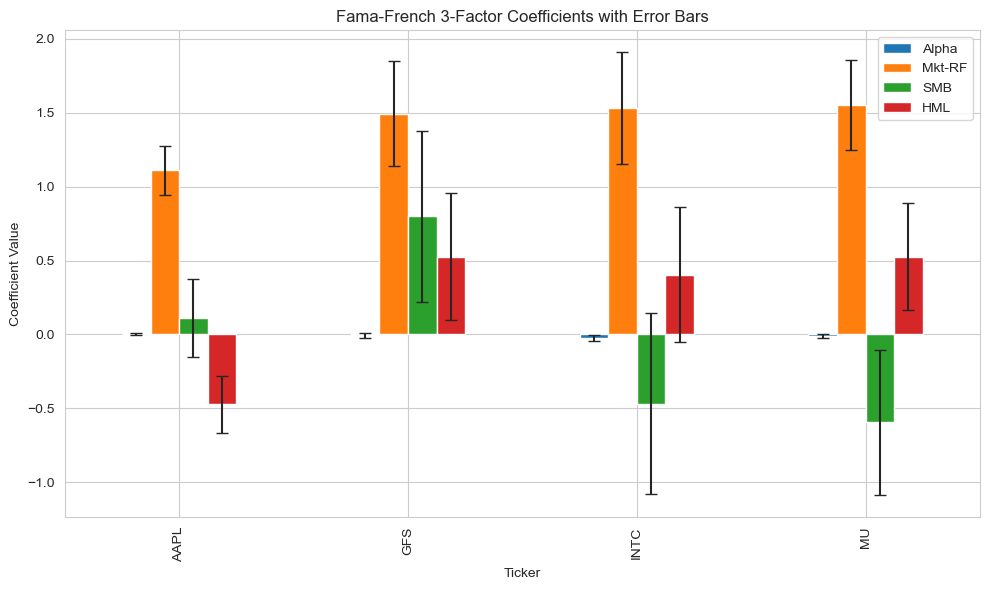

Ticker          AAPL       GFS      INTC        MU
Alpha       0.001484 -0.005893 -0.025155 -0.008765
Mkt-RF      1.109509  1.494232  1.530915  1.553092
SMB         0.111674  0.799710 -0.467861 -0.594846
HML        -0.474060  0.526381  0.405006  0.526898
Alpha_err   0.007814  0.017072  0.018146  0.014533
Mkt-RF_err  0.162575  0.355178  0.377520  0.302354
SMB_err     0.264894  0.578716  0.615119  0.492647
HML_err     0.195758  0.427673  0.454575  0.364068


In [81]:
# Step 5: Generate Regression summary and Coefficients for Alpha, Mkt-RF, SMB, HML per Ticker
# Initialize lists
model,coef_df = ff3_regression_analysis(merged_data)
print (coef_df)

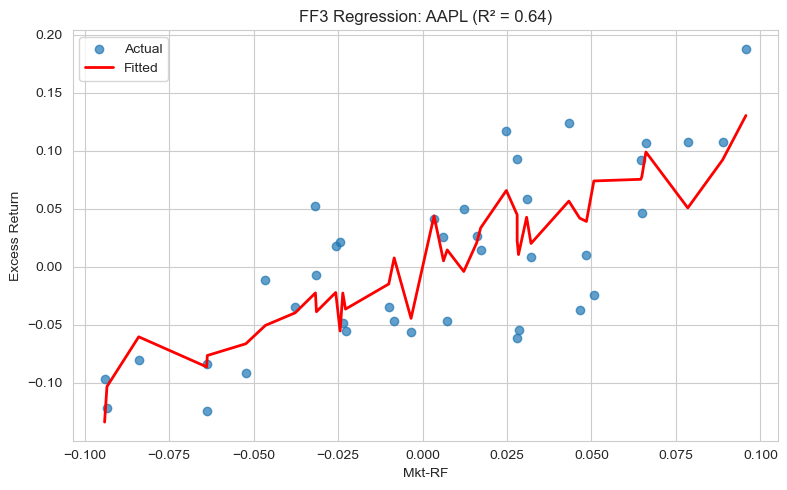

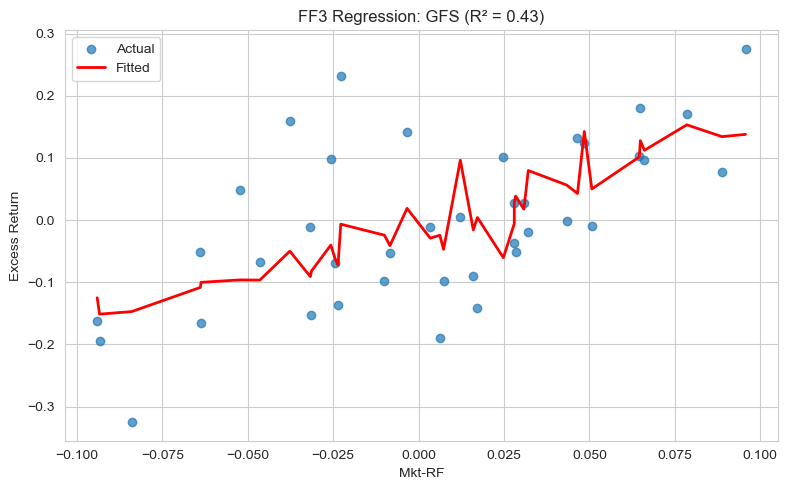

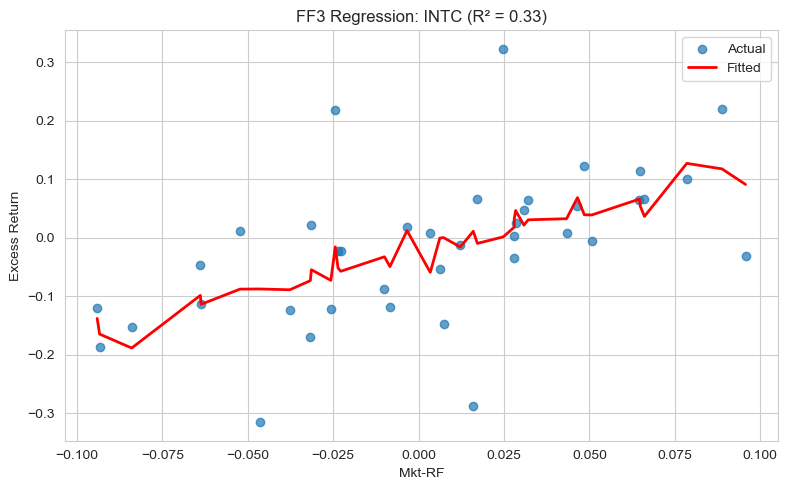

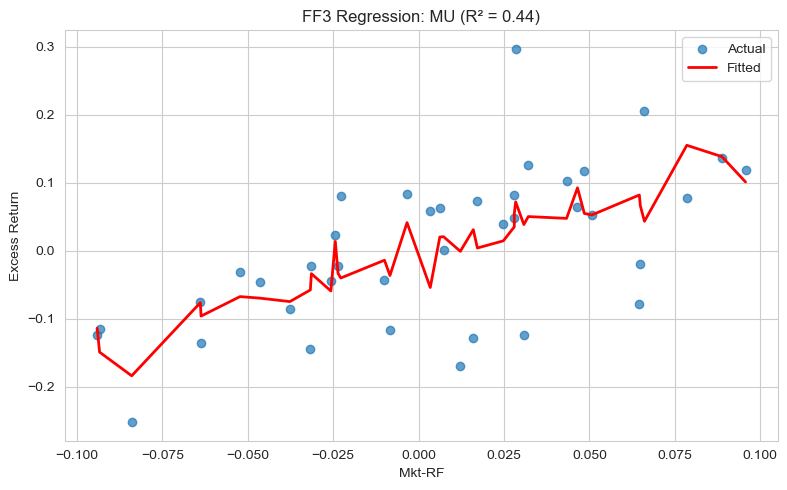

In [83]:
# Step 6: Plotting actual vs.fitted regression per ticker
ff3_fitted_plt(merged_data)

In [113]:
# Step 6: Portfolio optimization with FF3
# Prompt user
response = input("Proceed with portfolio optimization based on FF3 regression? (y/n): ").strip().lower()

if response == "y":
    if len(tickers) > 1:
        # Ask user to specify risk aversion
        print("\n🎯 Risk Aversion Level (higher = more conservative):")
        print(" - 1–5   ➜ Aggressive (maximize returns)")
        print(" - 10–20 ➜ Balanced (moderate risk-return trade-off)")
        print(" - 30+   ➜ Conservative (prefer low volatility)")
        try:
            risk_aversion = float(input("Enter your risk aversion level (e.g., 10): ").strip())
        except ValueError:
            print("❌ Invalid risk aversion input. Using default = 10.")
            risk_aversion = 10

Proceed with portfolio optimization based on FF3 regression? (y/n):  y



🎯 Risk Aversion Level (higher = more conservative):
 - 1–5   ➜ Aggressive (maximize returns)
 - 10–20 ➜ Balanced (moderate risk-return trade-off)
 - 30+   ➜ Conservative (prefer low volatility)


Enter your risk aversion level (e.g., 10):  10


In [117]:

print(cov_matrix)

[[0.00567136 0.00490806 0.00430689 0.00254944]
 [0.00490806 0.01687208 0.00684873 0.00621278]
 [0.00430689 0.00684873 0.0161988  0.00743239]
 [0.00254944 0.00621278 0.00743239 0.01377896]]


In [131]:
# Step 6: Portfolio optimization with FF3
# Prompt user
response = input("Proceed with portfolio optimization based on FF3 regression? (y/n): ").strip().lower()

if response == "y":
    if len(tickers) > 1:
        # Ask user to specify risk aversion
        print("\n📍 Risk Aversion Level (higher = more conservative):")
        print(" - 1–5   ➜ Aggressive (maximize returns)")
        print(" - 10–20 ➜ Balanced (moderate risk-return trade-off)")
        print(" - 30+   ➜ Conservative (prefer low volatility)")

        user_input = input("Enter your risk aversion level (e.g., 10): ").strip()
        try:
            risk_aversion = float(user_input)
        except ValueError:
            print("❌ Invalid risk aversion input. Using default = 10.")
            risk_aversion = 10

        # Run optimization
        weights_df = optimize_portfolio_ff3_risk_adjusted(coef_df, ff3, returns, risk_aversion)

        # Clean and print
        w['Weight'] = np.where(np.abs(w['Weight']) < 1e-5, 0, w['Weight'])
        w['Weight'] = w['Weight'].round(4)
        print("✅ Portfolio optimized weights:\n", w)

    else:
        print(f"⚠️ Only one ticker provided: {tickers[0]}. Weight is 100%.")
else:
    print("🚫 Portfolio optimization skipped.")


Proceed with portfolio optimization based on FF3 regression? (y/n):  y



📍 Risk Aversion Level (higher = more conservative):
 - 1–5   ➜ Aggressive (maximize returns)
 - 10–20 ➜ Balanced (moderate risk-return trade-off)
 - 30+   ➜ Conservative (prefer low volatility)


Enter your risk aversion level (e.g., 10):  15


ValueError: All arrays must be of the same length

In [107]:
print(returns)

Ticker          AAPL       GFS      INTC        MU
Date                                              
2022-02-01 -0.055270  0.231861 -0.022941  0.080102
2022-03-01  0.058821  0.026983  0.046908 -0.123453
2022-04-01 -0.097131 -0.162288 -0.120460 -0.124534
2022-05-01 -0.055883  0.141518  0.019041  0.084336
2022-06-01 -0.080080 -0.324175 -0.151155 -0.251354
2022-07-01  0.188634  0.276153 -0.029404  0.119030
2022-08-01 -0.032552  0.162005 -0.120903 -0.084373
2022-09-01 -0.119756 -0.191742 -0.184519 -0.113745
2022-10-01  0.109551  0.172699  0.103221  0.079840
2022-11-01 -0.034629  0.134921  0.057686  0.067868
2022-12-01 -0.120816 -0.162549 -0.109180 -0.133044
2023-01-01  0.110521  0.100019  0.069239  0.209228
2023-02-01  0.021623  0.102227 -0.117834 -0.041128
2023-03-01  0.120357  0.104683  0.326437  0.043583
2023-04-01  0.028987 -0.185370 -0.049280  0.066622
2023-05-01  0.044613 -0.007993  0.012234  0.061806
2023-06-01  0.095844  0.107149  0.067969 -0.074633
2023-07-01  0.012786 -0.013781 

In [ ]:
        # Replace very small weights (abs < 1e-5) with 0
        w['Weight'] = np.where(np.abs(w['Weight']) < 1e-5, 0, w['Weight'])
        # Optional: round to 4 decimals for display
        w['Weight'] = w['Weight'].round(4)
        
        # Print cleaned weights
        print("✅ Portfolio optimized weights:\n", w)
    else:
        print(f"⚠️ Only one ticker provided: {tickers[0]}. Weight is 100%.")
else:
    print("🚫 Portfolio optimization skipped.")